In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import os

import sys
sys.path.append('../Notebooks')
from mypackage.ploting_functions import *

## objective :

In this notebook, we define a wind field on $\mathbb{R}^3$ and perform semi-lagrangian and bilinear interpolation to advect a chemical tracer.

## defining the lat/lon grid :

In [44]:
n = 400
m,n = 2*n, n # number longitudes, number of latitudes 
phi,theta = np.linspace(-np.pi, np.pi - 2*np.pi / m, m), np.linspace(-np.pi/2,np.pi/2,n)
THETA, PHI = np.meshgrid(range(n),range(m))
deg_to_radian = 2*np.pi/360

theta, phi = np.meshgrid(theta, phi)
dtheta = np.abs(theta[0,0]-theta[0,1])
dphi = np.abs(phi[0,0]-phi[1,0])

R = 1

ex,ey,ez = np.eye(3)


e_r = np.array([np.cos(theta)*np.cos(phi),
               np.cos(theta)*np.sin(phi),
               np.sin(theta)]) * R

e_theta = np.array([-np.sin(theta)*np.cos(phi),
               -np.sin(theta)*np.sin(phi),
               np.cos(theta)]) * R

e_phi = np.array([-np.cos(theta)*np.sin(phi),
                 np.cos(phi)*np.cos(theta),
                 np.cos(theta)*0]) * R


X = R * np.cos(theta)*np.cos(phi)
Y = R * np.cos(theta)*np.sin(phi)
Z = R * np.sin(theta)

OM = X[:,:,np.newaxis]*ex + Y[:,:,np.newaxis]*ey + Z[:,:,np.newaxis]*ez

def projection(vecteur):
    return (np.dot(vecteur,ex),np.dot(vecteur,ey),np.dot(vecteur,ez))

## initial concentration :

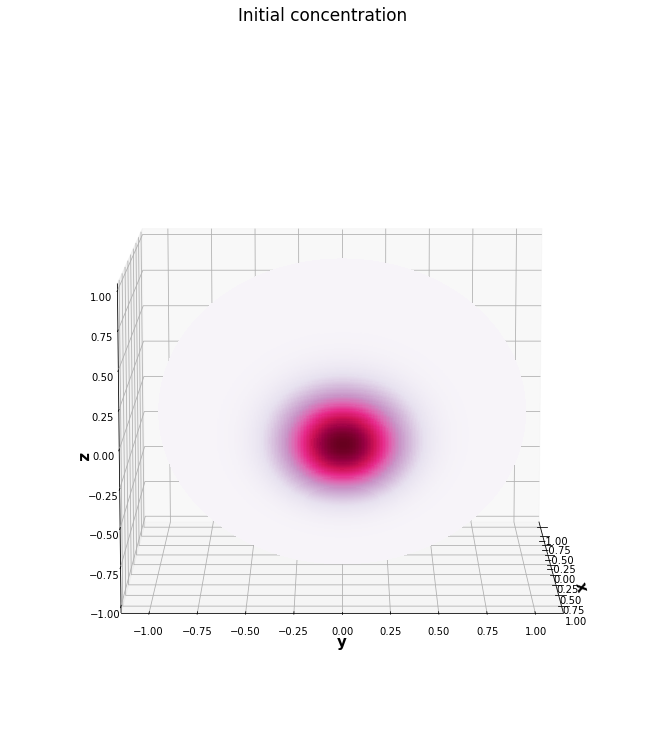

In [45]:
x,y,z = 1,0,0
lh = 0.3


distX = X-x
distY = Y-y
distZ = Z-z
dist = np.linalg.norm(np.array([distX,distY,distZ]),ord=2,axis=0)  

X0 = np.exp(- dist **2 / lh**2)

plot_sphere(X,Y,Z,X0,elev=10,azim=0,title='Initial concentration',figsize=(12,12));

## defining the Spherical advection class :

In [53]:
from mypackage.problem import Model
class SemiLagShericalAdv(Model):
    def _make_trend(self):
        wind_x, wind_y, wind_z = self.trend_parameters[0]
        
        # computing departures points in R^3 :
        Xd = X - self.dt*wind_x
        Yd = Y - self.dt*wind_y
        Zd = Z - self.dt*wind_z
        
        # projecting them onto the sphere (approximation) :
        norm_d = np.linalg.norm(np.array([Xd,Yd,Zd]),axis=0)
        Xd = Xd/norm_d
        Yd = Yd/norm_d
        Zd = Zd/norm_d
        
        #converting them to (theta,phi) system of coordinates :
        phid = np.arctan2(Yd,Xd)
        thetad = np.arcsin( Zd/(Xd**2+Yd**2+Zd**2)**.5)

        #getting their indices :
        self.PHId = ((phid + np.pi)/(2*np.pi) * (m))  * 0.999999
        self.THETAd = ((thetad + np.pi/2)/(np.pi) * (n-1))
        
    def _step(self, new_dt=None):
        self.x = BilinearSpherical(self.THETAd, self.PHId, self.x)
        #saving :
        self.t += self.dt
        if self.save and (self.time_saving_interval =="all"  or self.t - self.last_saved_time >= self.time_saving_interval) :
            self.saved_times.append(self.t)
            self.trajectory[self.t] = self.x
            self.last_saved_time = self.t

In [54]:
def BilinearSpherical(THETAd, PHId, state):
    # do bilinear interpolation on "rectangles" defined by the lat/lon grid.
    
    PHI_ = PHId.astype(int)
    PHIp_ = (PHId+1).astype(int) % m  # 
    THETA_ = THETAd.astype(int)
    THETAp_ = (THETAd+1).astype(int)
    
    interpolation = (1-THETAd%1)         *(  (1-PHId%1) * state[PHI_      , THETA_        ]
                                           + (PHId % 1) * state[PHIp_ , THETA_        ] ) \
                +  (THETAd % 1)          *(  (1-PHId%1) * state[PHI_      , THETAp_  ]
                                           + (PHId % 1) * state[PHIp_ , THETAp_  ] )
    
    return interpolation

# Rotation along the $z$-axis : a walk on the equator

In the $(\theta, \phi)$ system of coordinates, the wind field correponding to a constant rotation along the $z$-axis writes $u=(u_\theta, u_\phi) = (0, 1)$, where 1 is the angular velocity.

In [60]:
wind_xyz = e_phi
### normalizing the wind field :
wind_xyz = wind_xyz/np.linalg.norm(wind_xyz,axis=0).max()
max_wind_speed = 50 #kmh
D = 6370 #earth radius in km
wind_xyz = wind_xyz/D * max_wind_speed

In [61]:
t_end = 2*np.pi*D / max_wind_speed # time for one revolution.
dt = .25  #time step in hour

SL = SemiLagShericalAdv(X0, dt=dt, trend_parameters=[wind_xyz],time_saving_interval=20)
SL.forecast(t_end)

  0%|                                                                                         | 0/3202 [00:00<?, ?it/s]

IndexError: index 400 is out of bounds for axis 1 with size 400

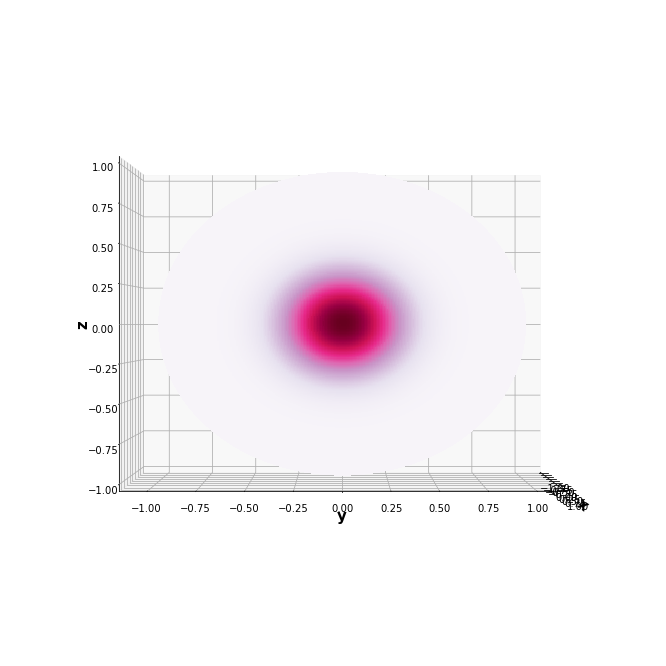

In [64]:
plot_sphere(X,Y,Z, SL.x,
            elev=0,azim=0,
            title=None,
            figsize=(12,12));

We observe some diffusion along the latitude lines : this is due to the bilinear interpolation method.

## Mass variation during experiment :

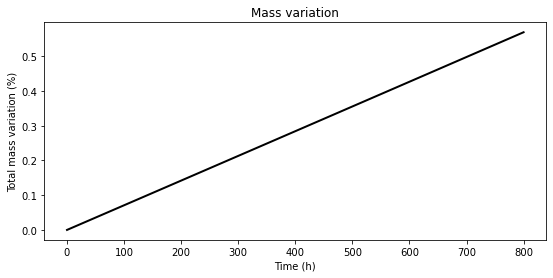

In [43]:
traj = np.array(list(SL.trajectory.values()))
mass = traj.sum(axis=(1,2))
mass_variation = (mass/mass[0] - 1)*100
plt.figure(figsize=(9,4))
plt.plot(SL.saved_times,mass_variation,c='k',linewidth = 2 )
plt.title("Mass variation");
plt.ylabel("Total mass variation (%)")
plt.xlabel("Time (h)");

# Half-rotation along the $x$-axis : crossing the poles

In [68]:
def wind(x,y,z):
    phi = np.arctan2(y,x)
    theta = np.arcsin(z/(x**2+y**2+z**2)**.5)
    
    wind = np.array([
        -np.cos(theta)*np.sin(phi),
        np.cos(theta)*np.cos(phi),
        theta * 0
    ])    
    return wind

wind2 = wind(Z,-X,Y)
wind2 = np.array([wind2[1],wind2[2],-wind2[0]])

wind2 = wind2/np.linalg.norm(wind2,axis=0).max()
max_wind_speed = 50 #kmh
D = 6370 #earth radius in km
wind2 = wind2/D * max_wind_speed

### wind intensity plot :

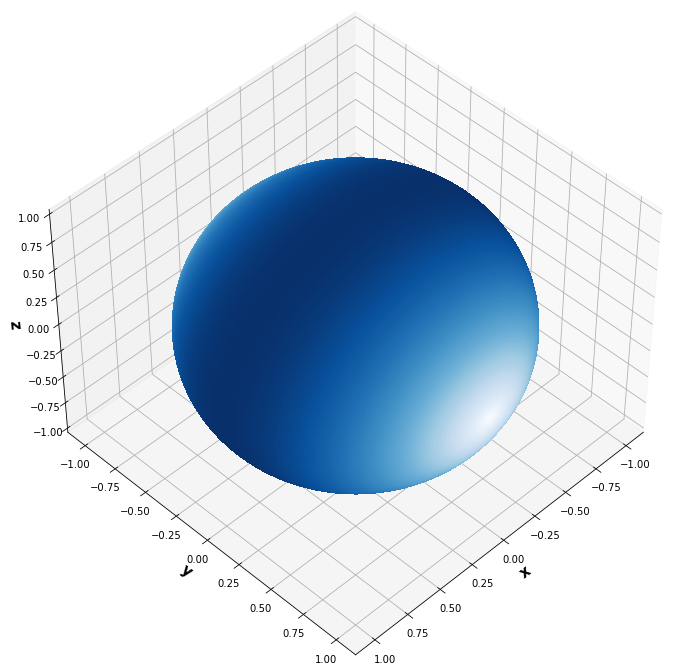

In [69]:
plot_sphere(X,Y,Z,np.linalg.norm(wind2,axis=0),
            cmap=cm.Blues,
            elev=45,azim=45,
            title=None,
            figsize=(12,12));

In [70]:
t_end = np.pi*D / max_wind_speed # time for crossing one pole and land on the exact opposite point.
dt = .25  #time step in hour

SL = SemiLagShericalAdv(X0, dt=dt, trend_parameters=[-wind2],time_saving_interval=20)
SL.forecast(t_end)

100%|██████████████████████████████████████████████████████████████████████████████| 1601/1601 [04:16<00:00,  6.24it/s]


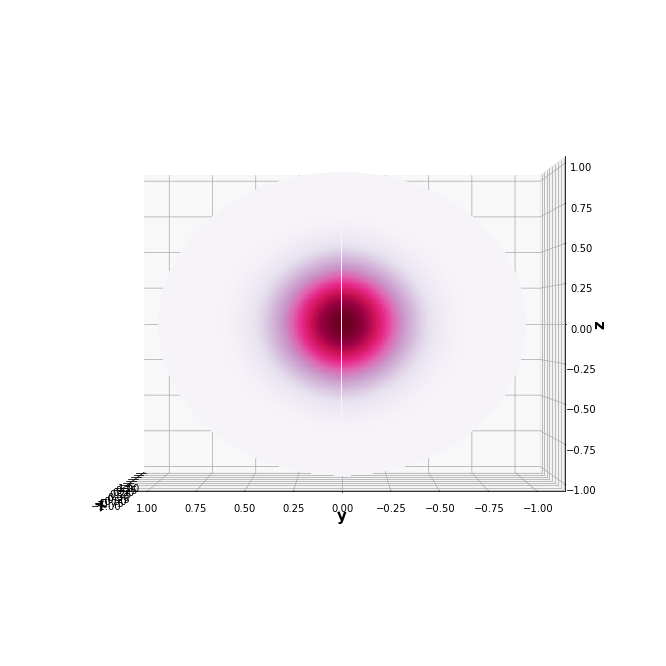

In [71]:
plot_sphere(X,Y,Z, SL.x,
            elev=0,azim=180,
            title=None,
            figsize=(12,12));

No deformation is visible after half a rotation over the pole.

## Mass variation during experiment :

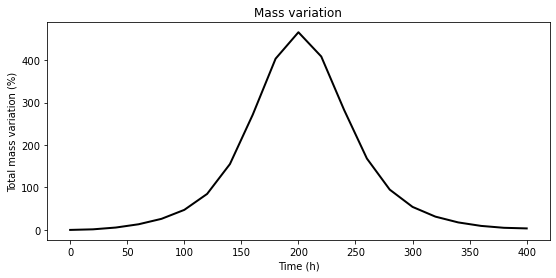

In [72]:
traj = np.array(list(SL.trajectory.values()))
mass = traj.sum(axis=(1,2))
mass_variation = (mass/mass[0] - 1)*100
plt.figure(figsize=(9,4))
plt.plot(SL.saved_times,mass_variation,c='k',linewidth = 2 )
plt.title("Mass variation");
plt.ylabel("Total mass variation (%)")
plt.xlabel("Time (h)");

# With random isotropic wind fields

In [73]:
import pyshtools as sh  #py spherical harmonics tools package https://shtools.github.io/SHTOOLS/index.html
from scipy.special import factorial

def random_isotropic_field(m,n, Lmax=20,alpha=0.7):
    phi,theta = np.linspace(-np.pi,np.pi,m), np.linspace(-np.pi/2,np.pi/2,n)
    ls = [ [index] * (index+1) for index in range(0,Lmax+1)]
    ms=  [  list(range(0,l+1)) for l in range(0,Lmax+1)  ]

    ls = np.array(np.sum(ls))
    ms = np.array(np.sum(ms))

    Llm =    (  (factorial(ls-ms)/factorial(ls+ms) * (2*ls+1)/(4*np.pi))**.5  ) * \
        np.array([sh.legendre.legendre_lm(ls,ms, np.sin(_theta),normalization='unnorm') for _theta in theta]) 

    # influence the length-scales by putting more or less weigth on the spherical harmonics of higher order.
    Al = .7**np.arange(0,Lmax+1,1)

    Ll0_index = [n*(n+1)//2 for n in range(Lmax+1)]

    T = np.zeros((m,n))*1.0
    for l, Al_coef in enumerate(Al):
        T += Al_coef**.5 * Llm.T[Ll0_index[l]] * np.random.normal(0,1)

        for m in range(1,l):
            mm  = Ll0_index[l] + m
            T += (2*Al_coef)**.5 * Llm.T[mm] * (np.random.normal(0,1) * np.cos(m*phi)[:,np.newaxis] + 
                                              np.random.normal(0,1) * np.sin(m*phi)[:,np.newaxis])
    return T

In [74]:
wind = np.array([random_isotropic_field(m,n) for i in range(3)])

wind -= (wind * e_r).sum(axis=0) * e_r ## removing the normal component of the wind

wind = wind/np.linalg.norm(wind,axis=0).max()
max_wind_speed = 130 #kmh
D = 6370 #earth radius in km
wind = wind/D * max_wind_speed

C:\Users\antoi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### wind intensity plot

In [ ]:
plot_sphere(X,Y,Z,np.linalg.norm(wind,axis=0),
            cmap=cm.Blues,
            elev=45,azim=45,
            title=None,
            figsize=(16,16));

### forecasting an initial random field of concentration

In [98]:
error = random_isotropic_field(m,n)

X02 = 1 + error/10
t_end = 24*2.5 
dt = .25      #time step in hour
SL = SemiLagShericalAdv(X02, dt=dt, trend_parameters=[wind],time_saving_interval=.25)
SL.forecast(t_end)

C:\Users\antoi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:37<00:00,  6.40it/s]


In [99]:
def make_plot_sphere(INDEX_TIME,cmin,cmax, ds=1,cmap=cm.RdBu,title=None):
    fig = plot_sphere(X,Y,Z,SL[SL.saved_times[INDEX_TIME]],
            cmap=cmap,
            elev=45,azim=45,
            ds =ds,
            title=title,
            cmin=cmin,cmax=cmax,
            figsize=(22,22))
    return  fig

In [102]:
titles = ['Advection of a tracer by a random isotropic wind, ' + f'$t={T:.2f}$h' for T in SL.saved_times]

saving_dir = '../../../Pictures/plots/'
img_name='SphereAdvection'

cmin,cmax = np.min(list(SL.trajectory.values())), np.max(list(SL.trajectory.values()))
ploting_args= (
    cmin,cmax,
    1,
    cm.BuPu,)
save_plots(saving_dir, img_name, make_plot_sphere, range(len(SL.saved_times)),titles, ploting_args)


make_gif(saving_dir, 'animated_plots/',img_name)

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<img src="animated_plots/SphereAdvection.gif">

### making a video file :

In [105]:
import cv2
import glob

img_array = []
for filename in glob.glob(saving_dir + '*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


    
out = cv2.VideoWriter( 'animated_plots/'+img_name+'.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 28, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

## Mass variation during experiment :

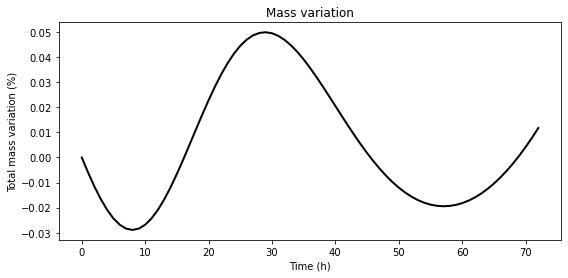

In [79]:
traj = np.array(list(SL.trajectory.values()))
mass = traj.sum(axis=(1,2))
mass_variation = (mass/mass[0] - 1)*100
plt.figure(figsize=(9,4))
plt.plot(SL.saved_times,mass_variation,c='k',linewidth = 2 )
plt.title("Mass variation");
plt.ylabel("Total mass variation (%)")
plt.xlabel("Time (h)");